In [1]:
from sklearn import datasets
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans,AgglomerativeClustering
from numpy import linalg
import pandas as pd
from sklearn.datasets import load_digits
#import zoopt
import csv

In [2]:
#from scipy import optimize
import blackbox as bb

In [3]:
plotting_on = 0
cluster_size = 2
noise_threshold = 10.0
S = 1

In [4]:
def plot_clusters(X, labels):
    chosen_pts_cluster_label = []
    for idx, label in enumerate(labels):
        if label == 0:
            if plotting_on:
                plt.scatter(X[idx,0], X[idx,1], color = 'blue')

        if label == 1:
            if plotting_on:
                plt.scatter(X[idx,0], X[idx,1], color = 'red')

        if mask[idx] == 1:
            chosen_pts_cluster_label.append(label)
            if plotting_on:
                plt.scatter(X[idx,0], X[idx,1], color = 'green')

    if plotting_on:
        plt.show()
    return chosen_pts_cluster_label

def get_Y(labels,n_samples, n_clusters):
    Y = np.zeros([n_samples, n_clusters])
    for idx, label in enumerate(labels):
        Y[idx, label] = 1
    return Y

def run_kmeans(n_clusters, X):
    kmeans = KMeans(n_clusters = n_clusters, random_state=42)
    labels = kmeans.fit_predict(X)
    centers = kmeans.cluster_centers_
    
    temp = np.copy(labels)
    temp_c = np.copy(centers)
    if np.sum(centers[0,:]) > np.sum(centers[1,:]):
        return (labels, centers) 
    else:
        labels[temp == 0] = 1
        labels[temp == 1] = 0
        centers[1,:] = temp_c[0,:]
        centers[0,:] = temp_c[1,:]
        return (labels, centers)
    
    
def add_noise(X,noise):
    for i,(m,_) in enumerate(zip(mask,X)):
        if m != 0:
            X[i,:] = X[i,:] + noise
    return X

def get_dist(Y,Y_dash):
    dist = linalg.norm(np.matmul(Y,Y.T) - np.matmul(Y_dash,Y_dash.T))
    return dist


In [5]:
d, y = [[],[],[],[],[],[],[]], []                                               
with open('seeds_dataset.txt') as f:                                            
    r = csv.reader(f, delimiter = ',')                                          
    for row in r:                                                               
        #print(row[0].split())                                                  
        for i in range(7):                                                      
            d[i].append(float(row[0].split()[i]))                               
        y.append(float(row[0].split()[7]))
                                                                                        
d = np.array(d).T                                                               
y = np.array(y)                                                                                                                          
X1 = d[y==1,:]                                                                  
X2 = d[y==2,:]                                                                  
X = np.vstack((X1, X2))                                                         
print(X1.shape,X2.shape, X.shape) 

sample_size = X.shape[0]
mask = np.zeros((sample_size))
n_features = X.shape[1]

X_org = np.copy(X)

kmeans_d = KMeans(n_clusters = cluster_size, random_state=42)
labels_d = kmeans_d.fit_predict(X)    
centers_d = kmeans_d.cluster_centers_

temp_d = np.copy(labels_d)
temp_c_d = np.copy(centers_d)
if np.sum(centers_d[0,:]) < np.sum(centers_d[1,:]):
    labels_d[temp_d == 0] = 1
    labels_d[temp_d == 1] = 0
    centers_d[1,:] = temp_c_d[0,:]
    centers_d[0,:] = temp_c_d[1,:]


best_vals = []
for idx,label in enumerate(labels_d):
    if label == 1:
        best_vals.append(linalg.norm(X[idx,:] - centers_d[0,:]))
    else:
        best_vals.append(1000000)

best_vals = np.array(best_vals)
best_vals_idx = np.argsort(best_vals)

count = 0
mask_idx = -1
for idx in range(0,sample_size):
    if idx in best_vals_idx[:S]:
        mask[idx] = 1
        count+=1
        mask_idx = idx


((70, 7), (70, 7), (140, 7))


(61, 79)
[[0, 2.5429836065573785], [0, 1.1521147540983592], [-0.0015131147540984324, 0], [0, 0.5400278688524597], [0, 0.21743934426229525], [-0.6134098360655735, 0], [0, 0.4929081967213109]]


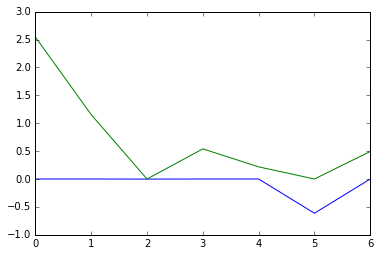

In [6]:
mean_0, mean_1  = np.zeros([7]), np.zeros([7])
for i,l in enumerate(labels_d):
    if l == 0:
        mean_0 += X_org[i]
    if l == 1:
        mean_1 += X_org[i]
mean_0, mean_1 = mean_0/np.sum(1-labels_d), mean_1/np.sum(labels_d)
print(np.sum(1-labels_d), np.sum(labels_d))

#plt.plot(mean_0-mean_1)
#plt.plot(mean_1)
#plt.show()

delta = centers_d[0,:] - X_org[mask_idx]
Delta = []
for i,d in enumerate(delta):
    if d > 0:
        Delta.append([0,d*1.1])
    elif d < 0:
        Delta.append([d*1.0, 0])
    elif d == 0:
        Delta.append([0,0])
    else:
        Delta.append([0,0])
print(Delta)
plt.plot(Delta)
plt.show()

In [7]:
def f(x):
    success = 0.0
    noise = np.array(x)
    (labels, centers) = run_kmeans(cluster_size, X_org)
    org_label = labels[mask_idx]
    Y = get_Y(labels, sample_size, cluster_size)
    X_noisy = np.copy(X_org)
    X_noisy  = add_noise(X_noisy, noise)
    (labels_dash, centers_dash) = run_kmeans(cluster_size, X_noisy)
    noisy_label = labels_dash[mask_idx]
    Y_dash = get_Y(labels_dash, sample_size, cluster_size)  
    dist = get_dist(Y,Y_dash)
    #if noisy_label != org_label and dist != 0.0:
    #    return -10000.0 - dist
    #else:
    #    return 1000000.0
    #    success = 1.0
    #return (linalg.norm(noise)-(dist + 10000*success))
    if dist != 0.0:
        #return -dist + linalg.norm(noise)
        return -dist
    else:
        return 1000000.0

In [8]:
bb.search(f=f,  # given function
          box=Delta,  # range of values for each parameter (2D case)
          n=40,  # number of function calls on initial stage (global search)
          m=40,  # number of function calls on subsequent stage (local search)
          batch=4,  # number of calls that will be evaluated in parallel
          resfile='kmeans_seeds_1-2.csv')  # text file where results will be saved

In [8]:
#best_noise = [ -5.8600e-02, +2.5402e+00, -2.4385e+00, +4.7911e+00, +4.0338e+00, -4.8885e+00, -2.1378e+00]
best_noise = [+1.6839e-01, +7.6773e-02, -6.5170e-04, +5.0622e-02, +1.9871e-01, -3.0331e-01, +9.8439e-02]
np.save('kme_X_org.npy', X_org)
np.savetxt('X_org.csv', X_org, delimiter = ',')
X_adv = np.copy(X_org)
X_adv = add_noise(X_adv, best_noise)
np.save('kme_X_adv.npy', X_adv)
np.savetxt('X_adv.csv', X_adv, delimiter = ',')
print(mask_idx)

100


In [9]:
Xo = np.load('kme_X_org.npy')
Xa = np.load('kme_X_adv.npy')

lo,_ = run_kmeans(2, Xo)
la,_ = run_kmeans(2, Xa)

In [10]:
print(lo,la)
np.savetxt('lo.csv', lo)
np.savetxt('la.csv', la)

(array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 0, 1, 1, 1], dtype=int32), array([1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 0, 1, 1, 1], dtype=int32))


In [11]:
print(lo[lo==0].shape, lo[lo==1].shape)
print(lo[mask_idx],la[mask_idx])

((61,), (79,))
(1, 0)


In [12]:
count_diffs = 0
perturbed_idx = []
for idx,(el1, el2) in enumerate(zip(lo,la)):
    if el1 != el2:
        count_diffs += 1
        perturbed_idx.append(idx)
print(count_diffs)

2


In [13]:
f(best_noise)

-23.49468024894146

In [14]:
for i in perturbed_idx:
    print(lo[i], la[i], y[i])

(1, 0, 1.0)
(1, 0, 2.0)


In [14]:
y

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
       2., 2., 2., 2., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3., 3.,
       3., 3., 3., 3., 3., 3.])

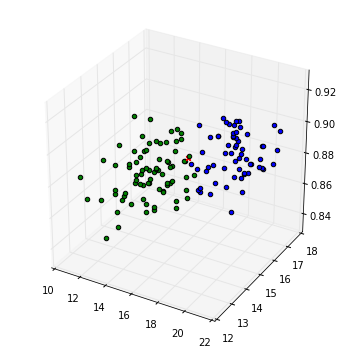

In [36]:
fig = plt.figure()
#fig2 = plt.figure()
fig.set_figheight(6)
fig.set_figwidth(6)
#fig2.set_figheight(10)
#fig2.set_figwidth(10)
ax = fig.add_subplot(111, projection='3d')#
#ax2 = fig2.add_subplot(111, projection='3d')
#ax.scatter(Xo[:,0], Xo[:,1], Xo[:,2], c='r', marker='o')
for i,xo in enumerate(Xo):
    if i == mask_idx:
            ax.scatter(xo[0], xo[1], xo[2], c='r', marker='x')
            ax.scatter(xo[0], xo[1], xo[2], c='r', marker='x')
            ax.scatter(xo[0], xo[1], xo[2], c='r', marker='x')
            ax.scatter(xo[0], xo[1], xo[2], c='r', marker='x')
            ax.scatter(xo[0], xo[1], xo[2], c='r', marker='x')
            ax.scatter(xo[0], xo[1], xo[2], c='r', marker='x')
            ax.scatter(xo[0], xo[1], xo[2], c='r', marker='x')
            continue
    if lo[i] == 0:        
        ax.scatter(xo[0], xo[1], xo[2], c='b', marker='o')
    if lo[i] == 1:        
        ax.scatter(xo[0], xo[1], xo[2], c='g', marker='o')